In [141]:
import networkx as nx
import torch
print("PyTorch has version {}".format(torch.__version__))

PyTorch has version 1.11.0


#### References
1. http://podcasts.ox.ac.uk/introduction-deep-learning-and-graph-neural-networks-biomedicine
2. https://towardsdatascience.com/graph-neural-networks-in-python-c310c7c18c83
3. https://distill.pub/2021/gnn-intro/ and https://colab.research.google.com/drive/17eRoYIBxlgxAMKHV4qmXmBYL2-Wkl3Xx?usp=sharing
4. [Pytorch Docs](https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html)

## Using shapefile data

In [92]:
from os.path import join
import geopandas as gpd
from pysal.lib import weights
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.preprocessing import MinMaxScaler
import torch

/Users/alisonpeard/Documents/Oxford/DPhil/hybridmodels/idai/python


number of nodes: 1439
[num_nodes, num_node_features]: (1439, 11)
y vector length: 1439


/Users/alisonpeard/miniconda3/envs/hybridmodels/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 6 disconnected components.
 There are 3 islands with ids: 1347, 1404, 1438.
  warnings.warn(message)


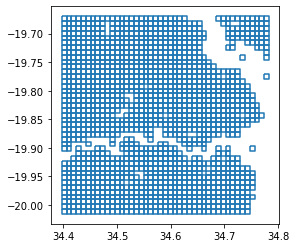

In [105]:
# load the geopandas dataframe and build adjacency matrix
root_dir = join("..", "beira", "outdata", "feature_stats.shp")
feature_gdf = gpd.read_file(root_dir).dropna()
feature_gdf.boundary.plot()
print("number of nodes:", len(feature_gdf))
feature_gdf = feature_gdf.drop(["jrc_permwa"], axis=1)
feature_list = [*feature_gdf.columns]
feature_list.remove("floodfrac")
feature_list.remove("geometry")

# calculate contiguity weights matrix
w = weights.contiguity.Queen.from_dataframe(feature_gdf)
W, ids = weights.full(w)

# use networkx to extract edge_list and convert to pyg-desired format
G = nx.from_numpy_array(W)
edge_index = torch.tensor([list(e) for e in G.edges()], dtype=torch.long)
edge_index = edge_index.t().contiguous()

# node feature matrix with shape [num_nodes, num_node_features]
X, y = feature_gdf[feature_list], feature_gdf["floodfrac"]

# scale input features
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(X)
X = scaler.transform(X)
x = torch.tensor(X, dtype=torch.float)
print(f"[num_nodes, num_node_features]: {X.shape}")

# data.y
y = feature_gdf.floodfrac
print("y vector length:", len(y))


In [140]:
# now define a data instance
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data

data = Data(x=x, edge_index=edge_index, y=y)

# create a train/test-split
index = [*feature_gdf.index]
train_idx, test_idx = train_test_split(index, test_size=0.1)
train_idx, val_idx = train_test_split(train_idx, test_size=0.1 / 0.9)

data.train_idx = torch.tensor(train_idx, dtype=torch.long)
data.val_idx = torch.tensor(val_idx, dtype=torch.long)
data.test_idx = torch.tensor(test_idx, dtype=torch.long)